In [6]:
import numpy as np

## Main problems in making a simulation:
1. In solving CS model with solve_ivp - the main problem is write fast rhs function.
2. Solving using solve_ivp
3. Making an animation out of data.

### 0. Before you start to write your RHS functions.
(in this case) it will be better to start with making functions which generate random data inputs
(or at least generate one input for testing) to test pieces of your code on every step while you are writing.

In [7]:
from numpy.random import default_rng, SeedSequence

### initial condition functions ###
def set_random_y0(N, seed, low=0, high=1, velo_st_dev=4):
    """Produces an initial CS_matrix"""
    rng = default_rng(SeedSequence(seed))
    
    x_s = rng.uniform(low=low, high=high, size=N) # x coordinates of intial position
    y_s = rng.uniform(low=low, high=high, size=N) # y coordinates of intial position

    vx_s = velo_st_dev*rng.standard_normal(N) # x coordinates of intial velocity
    vy_s = velo_st_dev*rng.standard_normal(N) # y coordinates of intial velocity

    y_0 = np.c_[x_s, y_s, vx_s, vy_s] #returns a CS_matrix - initial condition
    return y_0
set_random_y0(5,1234)

array([[ 0.97669977,  0.11809123, -2.04977484, -8.63655605],
       [ 0.38019574,  0.24176629,  5.29503583,  1.7389358 ],
       [ 0.92324623,  0.31853393, -3.44112077,  6.93315728],
       [ 0.26169242,  0.96407925,  2.0779728 ,  2.08053662],
       [ 0.31909706,  0.2636498 , -5.06057487, -4.00866318]])

### 1. CS right hand side
Model from https://people.mpi-inf.mpg.de/~mehlhorn/SeminarEvolvability/CuckerSmale.pdf \
We are going to write rhs for model in which every bird "see" every other bird, hence the equation for the behaviour of $i^{\text{th}}$ bird is:
\begin{equation}
\begin{split}
\dot{x_i} & = v_i \\
\dot{v_i} & = \sum_j \eta\!\left( \text{dist}(x_j,x_i)\right)\cdot\left(v_j-v_i\right)
\end{split}
\end{equation}
where $$\eta(s) = \frac{K}{(\sigma^2+s)^\beta}.$$

Notice that we are going to solve system of $N \times 4$ functions.\
We organize data into $N \times 4$ matrix, every row is a bird which is described by 4 numbers: 
first two - its position (call it temporarily $x_i$), last two - its velocity (call it temporarily $v_i$). This matrix is an input for the right hand side function.\
solve_ivp solves dy / dt = f(t, y) thus we can imagine we have an equation that looks like:
$$
\begin{pmatrix}
 x_1 & v_1 \\
 x_2 & v_2 \\
 \vdots & \vdots \\
 x_N & v_N
\end{pmatrix}'=\begin{pmatrix}
 v_1 & \sum\eta\!\left( \text{dist}(x_j,x_1)\right)\cdot\left(v_j-v_1\right) \\
 v_2 & \sum\eta\!\left( \text{dist}(x_j,x_2)\right)\cdot\left(v_j-v_2\right) \\
 \vdots & \vdots \\
 v_N & \sum\eta\!\left( \text{dist}(x_j,x_N)\right)\cdot\left(v_j-v_N\right)
\end{pmatrix}
$$
and we have to construct a function which for the matrix $y = [x\:v]$ constructs what you see on the right of the equation sign above.

In [8]:
""" Lets define some constants and communication weight (different than in original model for simplicity)"""
N = 5
def comm_weight(s):
    """Communication weight in Cucker-Smale model"""
    return np.float_power(s, -0.8, out=np.zeros_like(s), where=s!=0)

#### Why this and what doeas it mean:
```python
,where=s!=0
```
The strategy:
1. Split function rhs into two: one returns derivatives of position, the second returns the derivaties of velocities,
2. In the second using numpy arrays and numpy operations we construct the expression above while the first function(derivative of position) returns second two rows of the input.

In [11]:
from typing import Callable

def rhs_func(t: float, y: np.ndarray, mass: np.ndarray, comm_weight: Callable)-> np.ndarray:
    """ The splitting of dx and dv is done here. 
            t           : independent variable in the ODE
            y           : CS_data_point of the shape (N*4,)
            mass        : array of "masses" we can set that some birds are more important than other
            comm_weight : callable 'communication weight' funtion
        """
    # N = len(y)
    y = y.reshape(-1,4)    # this is for technical reasons = solve_ivp was not working for me with the .shape =(N, 4) so i'm using .shape=(N*4,)
    x_derivatives = rhs_d_pos(y)
    y_derivatives = rhs_d_vel(y, mass, comm_weight)
    rhs = x_derivatives + y_derivatives
    return rhs.ravel()

We have to define two funtions: rhs_d_pos and rhs_d_vel.\
Another benefit of those functions is that we are back at the shape (n,4).

In [9]:
""" return of rhs_d_pos will have the shape as input and compatible with last line rhs_func """
def rhs_d_pos(y):
    u = y.copy()
    u[:,0], u[:,1] = 0, 0    # zeroing the position
    return u[:,[2,3,0,1]]    # velocities go to the front

y_test = set_random_y0(N,1234)
# print(y_test) 
# rhs_d_pos(y_test) # check

In [13]:
""" Now the harder part: rhs_d_vel """
# start 
def rhs_d_vel(y, mass=0, comm_weight=0):
    vel = y.copy()
    vel[:,0], vel[:,1] = 0, 0   # zeroing the position
    pos = y.copy()
    pos[:,2], pos[:,3] = 0, 0   # zeroing the velocity
    result = np.zeros(y.shape)  # place for the result
    
    # creating list of matricies of differences .shape=(N,N,4)
    
    
    return result
    
print(y_test) 
rhs_d_vel(y_test) # check

[[ 0.97669977  0.11809123 -2.04977484 -8.63655605]
 [ 0.38019574  0.24176629  5.29503583  1.7389358 ]
 [ 0.92324623  0.31853393 -3.44112077  6.93315728]
 [ 0.26169242  0.96407925  2.0779728   2.08053662]
 [ 0.31909706  0.2636498  -5.06057487 -4.00866318]]


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [47]:
# creating list of matricies of differences .shape=(N,N,4)
u = set_random_y0(5,1234)
u[:,0], u[:,1] = 0, 0    # zeroing the position

# inspect the following lines:
# np.stack([u]*N,axis=0)
# np.stack([u]*N,axis=1)

# draw on whiteboard what is going on, where are axes and how numpy stack arrays
# and explain np.stack([u]*N,axis=2) 
vel_diff = np.stack([u]*N,axis=0) - np.stack([u]*N,axis=1)
vel_diff.shape
# vel_diff

(5, 5, 4)

In [31]:
# procedure to obtain distances betweeen points is similar
pos = y_test.copy()
pos[:,2], pos[:,3] = 0, 0
# print(pos)
pos_diffs = np.stack([pos]*N,axis=0) - np.stack([pos]*N,axis=1)
print(pos_diffs)

[[[ 0.          0.          0.          0.        ]
  [-0.59650403  0.12367506  0.          0.        ]
  [-0.05345353  0.2004427   0.          0.        ]
  [-0.71500734  0.84598801  0.          0.        ]
  [-0.65760271  0.14555857  0.          0.        ]]

 [[ 0.59650403 -0.12367506  0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.5430505   0.07676764  0.          0.        ]
  [-0.11850331  0.72231295  0.          0.        ]
  [-0.06109868  0.02188351  0.          0.        ]]

 [[ 0.05345353 -0.2004427   0.          0.        ]
  [-0.5430505  -0.07676764  0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [-0.66155381  0.64554532  0.          0.        ]
  [-0.60414918 -0.05488412  0.          0.        ]]

 [[ 0.71500734 -0.84598801  0.          0.        ]
  [ 0.11850331 -0.72231295  0.          0.        ]
  [ 0.66155381 -0.64554532  0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.

Notice (like before) first array has 0 in the first row, the second has zero in the second row and so on.\
With singular weight without $\sigma^2$ it can be problem. Hence float_power has parameter called where (check documentation).\
It evaluates when the argument assined to where is True.

In [21]:
# Lets calculate norms of the vectors of pos_diffs.
# we need to apply np.linang.norm()
np.linalg.norm(pos_diffs) # <- doeas not do what we want 

3.0501745665126365

In [79]:
# we need to apply np.linalg.norm at the specific axis (check axis=0 and 1 for an exercise)
diffs = np.linalg.norm(pos_diffs, axis=2, keepdims=True)
# diffs

In [63]:
# now we are ready to apply comm_weight, by default 
weighted_diffs = comm_weight(np.linalg.norm(pos_diffs, axis=2, keepdims=True))
weighted_diffs

array([[[0.        ],
        [1.48661233],
        [3.51943603],
        [0.9214503 ],
        [1.37189168]],

       [[1.48661233],
        [0.        ],
        [1.61692745],
        [1.28352908],
        [8.91676417]],

       [[3.51943603],
        [1.61692745],
        [0.        ],
        [1.06497429],
        [1.49161542]],

       [[0.9214503 ],
        [1.28352908],
        [1.06497429],
        [0.        ],
        [1.32600619]],

       [[1.37189168],
        [8.91676417],
        [1.49161542],
        [1.32600619],
        [0.        ]]])

In [77]:
# now we multiply weighted_diffs by vel_diff (how we want multiply explain on whiteboard)
# There is a bonus of keeping (using keepdims=True) the shape of our array becasue multiplication that we are intrested in is... 
weighted_diffs*vel_diff

array([[[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,  10.91888606,  15.42433406],
        [  0.        ,   0.        ,  -4.89675302,  54.79661001],
        [  0.        ,   0.        ,   3.80351427,   9.8752682 ],
        [  0.        ,   0.        ,  -4.13049151,   6.34896771]],

       [[  0.        ,   0.        , -10.91888606, -15.42433406],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        , -14.12573141,   8.39867929],
        [  0.        ,   0.        ,  -4.12919396,   0.43845459],
        [  0.        ,   0.        , -92.33853844, -51.24998461]],

       [[  0.        ,   0.        ,   4.89675302, -54.79661001],
        [  0.        ,   0.        ,  14.12573141,  -8.39867929],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   5.87769276,  -5.16791624],
        [  0.        ,   0.        ,  -2.4156027 , -16.32098807]],

    

In [72]:
# lest check if this is waht we wanted, by chceckign if the first non zero output
# is the result of proper(in our heads) multiplication.

# print(weighted_diffs)
# print(vel_diff)

print(weighted_diffs[2,3]*vel_diff[2,3])

[ 0.          0.          5.87769276 -5.16791624]


In [76]:
# Now the sums, again we sum over proper axis
to_sum = weighted_diffs*vel_diff
np.sum(to_sum, axis =1 )


array([[   0.        ,    0.        ,    5.69515581,   86.44517999],
       [   0.        ,    0.        , -121.51234988,  -57.83718479],
       [   0.        ,    0.        ,   22.4845745 ,  -84.68419361],
       [   0.        ,    0.        ,  -15.01777149,  -13.2201232 ],
       [   0.        ,    0.        ,  108.35039105,   69.29632162]])

In [3]:
# pack all those steps into a function rhs_d_vel
def rhs_d_vel(y, mass=0, comm_weight=0):
    """ docs """
    #split position and velocity
    N = len(y)
    vel = y.copy()
    vel[:,0], vel[:,1] = 0, 0
    pos = y.copy()
    pos[:,2], pos[:,3] = 0, 0
    
    # stack of matricies of all diferences of velocities
    vel_diff = np.stack([vel]*N,axis=0) - np.stack([vel]*N,axis=1)
    
    # stack of matricies of all diferences of position
    pos_diffs = np.stack([pos]*N,axis=0) - np.stack([pos]*N,axis=1)
    
    # the values of eta function on distances 
    vcomm_weight = np.vectorize(comm_weight)
    weighted_diffs = vcomm_weight(np.linalg.norm(pos_diffs, axis=2, keepdims=True))
    
    return np.sum( weighted_diffs*vel_diff, axis=1 )

In [118]:
# notice :
# np.sum(rhs_d_vel(set_random_y0(6,1234),0,comm_weight), axis=0)
# rhs_func(0, set_random_y0(5,1234), mass=0, comm_weight=comm_weight)

### 2. Solving with solve_ivp

Start with definition of how many points and initial value y0.

In [13]:
n = 5
y0 = set_random_y0(n,1234)

Note: solve_ivp has callable which has to have two variables therfore you see lambda syntax below

In [14]:
from scipy.integrate import solve_ivp
birds = solve_ivp(lambda t, y: rhs_func(t , y, 0, comm_weight),
        (0, 1),
        y0.ravel(),
        method='RK45',
        # t_eval = np.linspace(self.t0, self.t0+self.duration, int(self.duration*self.fps/self.speed)),
        dense_output=True
        )
birds.message

'The solver successfully reached the end of the integration interval.'

#### Animation and interactive graph.
Beacasue we are using jupyter now it gets quite complicated.\
We need to install ipympl\
Code below is almost a copy from the site https://github.com/matplotlib/ipympl/blob/main/docs/examples/full-example.ipynb \
We need to check if it works for us and when it works then change to our data and our interactive picture.

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import AppLayout, FloatSlider

plt.ioff()

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=1.0,
    min=0.02,
    max=2.0
)

slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

fig = plt.figure()
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
plt.title('Plotting: y=sin({} * x)'.format(slider.value))

x = np.linspace(0, 20, 500)

lines = plt.plot(x, np.sin(slider.value * x))

def update_lines(change):
    plt.title('Plotting: y=sin({} * x)'.format(change.new))
    lines[0].set_data(x, np.sin(change.new * x))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_lines, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(FloatSlider(value=1.0, description='Factor:', layout=Layout(grid_area='footer', margin='0p…

Our picture is also 2D, we have one parameter t (time) which will be on the slider it seems we can easly change the above example.

In [21]:
# to access data we have .sol method
birds.sol(0.3).reshape(-1,4)[:,:2].T

array([[ 0.56234117,  0.81735982,  0.46354631,  0.46054219, -0.39639684],
       [-1.2354688 ,  0.3985368 ,  1.16297239,  1.33316102, -0.32085777]])

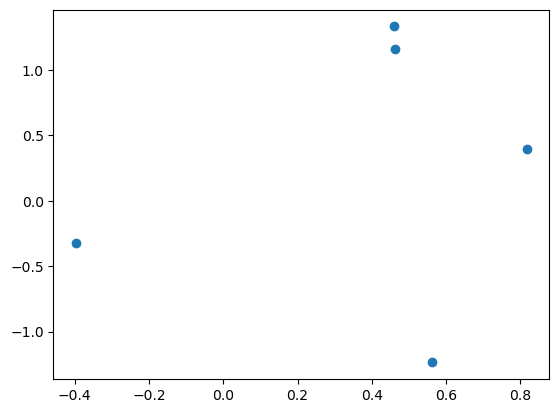

In [34]:
# jupyter magic (strings after %) changes many cells - if we only evaluate  plt.scatter(*birds.sol(0.3).reshape(-1,4)[:,:2].T) it draws in our tester sin cell.
# to go back to local cell drawing we can use with command %matplotlib inline
%matplotlib inline
plt.scatter(*birds.sol(0.3).reshape(-1,4)[:,:2].T)

In [31]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import AppLayout, FloatSlider

plt.ioff()

#we need to change slider to fit solution :
slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=0.02,
    min=0.01,
    max=0.99,
    step=0.01
)

slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

# fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
'Birds at the point: t={}'.format(slider.value)
plt.title('Birds at the point: t={}'.format(slider.value))

# x = np.linspace(0, 20, 500)
# lines = plt.plot(x, np.sin(slider.value * x))
# the above was drawing
def lines(t):
    fig, ax = plt.subplots()
    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    return plt.scatter(*(birds.sol(t).reshape(-1,4)[:,:2].T))

def update_lines(change):
    """ this function is "creating frames" and control what is happeing to interactive picture """
    plt.title('Birds at the point: t={}'.format(change.new)) 
    fig.clear()          # this line is clearing previous points
    lines(change.new)    # this is drawing our points
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_lines, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(FloatSlider(value=0.02, description='Factor:', layout=Layout(grid_area='footer', margin='0…

In [43]:
lines = plt.plot(x, np.sin(slider.value * x))
lines[0]